In [11]:
import os
import json
import statistics
from collections import Counter

import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthonywang64/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anthonywang64/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# Create the data/02_postprocessing direction if it does not exist
if not os.path.exists("data/02_postprocessing"):
    os.makedirs("data/02_postprocessing")
# Create the data/02_postprocessing/sample directory if it does not exist
if not os.path.exists("data/02_postprocessing/sample"):
    os.makedirs("data/02_postprocessing/sample")

In [13]:
def silent_remove(filename):
    try:
        os.remove(filename)
    except OSError:
        pass

This notebook is designed so that it can be run on the sample data or the full data just by switching one variable.

In [14]:
# Set this to True to run the script on the sample data
# Set this to False to run the script on the full data (takes much longer)
SAMPLE = False

## Ratings

This section performs rating normalization (technically standardization) to all ratings

In [44]:
# [!] 4 minutes to load
with open(f"data/01_cleaned/{'sample/' if SAMPLE else ''}ratings.json") as f:
    ratings_original = [json.loads(line) for line in f]
with open(f"data/01_cleaned/{'sample/' if SAMPLE else ''}users.json") as f:
    users_original = [json.loads(line) for line in f]

In [ ]:
user_ratings_dict = {}
for rating in ratings_original:
    user_id = rating["user_id"]
    if user_id not in user_ratings_dict.keys():
        user_ratings_dict[user_id] = {"rating_objs": [rating], "ratings": [(rating["rating_id"], rating["stars"])]}
    else:
        user_ratings_dict[user_id]["rating_objs"].append(rating)
        user_ratings_dict[user_id]["ratings"].append((rating["rating_id"], rating["stars"]))

In [ ]:
# Used to determine the cut off for how many ratings a user should have before we
# apply z-score normalization

# This outputs the ratio between the number of ratings that would be standardized
# and all ratings in the dataset

cutoff = 5
num_ratings = [len(user["ratings"]) for user in user_ratings_dict.values()]
rating_count = Counter(num_ratings)
rating_counter_agg = [(tup[0], tup[1], tup[0] * tup[1]) for tup in rating_count.items()]
ratio = sum([tup[2] for tup in rating_counter_agg if tup[0] >= cutoff]) / sum([tup[2] for tup in rating_counter_agg])
ratio

In [ ]:
users_not_standardized = []
users_standardized = []
for user_id, user_ratings in user_ratings_dict.items():
    if (
        len(user_ratings["ratings"]) >= cutoff
        and len(set(list(zip(*user_ratings["ratings"]))[1])) >= 2
    ):
        users_standardized.append(user_id)
        user_ratings["avg_rating"] = statistics.mean(
            list(zip(*user_ratings["ratings"]))[1]
        )
        user_ratings["std_dev"] = statistics.stdev(
            list(zip(*user_ratings["ratings"]))[1]
        )
        user_ratings["standardized_ratings"] = [
            (
                rating[0],
                (rating[1] - user_ratings["avg_rating"]) / user_ratings["std_dev"],
            )
            for rating in user_ratings["ratings"]
        ]
    else:
        users_not_standardized.append(user_id)

In [ ]:
# Gather all ratings standardized by user
user_standardized_ratings = [
    rating
    for user_ratings in [
        user_rating
        for user_rating in user_ratings_dict.values()
        if "standardized_ratings" in user_rating.keys()
    ]
    for rating in user_ratings["standardized_ratings"]
]

In [ ]:
# standardize all other ratings with respect to each other
not_standardized_ratings = [
    rating
    for user_ratings in [
        user_ratings_dict[user_id] for user_id in users_not_standardized
    ]
    for rating in user_ratings["ratings"]
]
mean = statistics.mean(list(zip(*not_standardized_ratings))[1])
std_dev = statistics.stdev(list(zip(*not_standardized_ratings))[1])
pool_standardized_ratings = [
    (rating[0], (rating[1] - mean) / std_dev) for rating in not_standardized_ratings
]

In [ ]:
ratings = {rating["rating_id"]: rating for rating in ratings_original}
for rating in user_standardized_ratings + pool_standardized_ratings:
    ratings[rating[0]]["standardized_rating"] = rating[1]

In [ ]:
# Add a min-max normalized standardized rating for each rating object
# The attribute will be called "norm_std_rating"

rating_df = pd.DataFrame(ratings_original).drop(
    columns=["business_id", "rating_id"]
)
max_std_rating = rating_df["standardized_rating"].max()
min_std_rating = rating_df["standardized_rating"].min()

rating_df["norm_std_rating"] = (
    (rating_df["standardized_rating"] - min_std_rating) /
    (max_std_rating - min_std_rating)
)
rating_df["norm_std_rating"] = (rating_df["norm_std_rating"] * 4) + 1
rating_df.head()

In [ ]:
# show the distribution of "norm_std_rating" with seaborn
sns.displot(rating_df["norm_std_rating"], stat="density", bins=10)

In [ ]:
# Make standardized_rating vs norm_std_rating a yes-no attribute
# Make it wide-form data
rating_df_wide_list = []
for index, row in rating_df.iterrows():
    rating_df_wide_list.append({
        "user_id": row["user_id"],
        "standardized": "Yes",
        "rating": row["norm_std_rating"],
    })
    rating_df_wide_list.append({
        "user_id": row["user_id"],
        "standardized": "No",
        "rating": row["stars"],
    })
rating_df_wide = pd.DataFrame(rating_df_wide_list)
rating_df_wide.head()

In [ ]:
# Find the user with the max average rating and the user with the min average rating

graphing_cutoff = 20
graph_pool = [
    user
    for user in users_standardized
    if len(user_ratings_dict[user]["ratings"]) >= graphing_cutoff
]
print(f"Narrowed down to {len(graph_pool) * 100 / len(users_standardized)}%")

max_avg_user = max(users_standardized, key=lambda x: user_ratings_dict[x]["avg_rating"])
min_avg_user = min(users_standardized, key=lambda x: user_ratings_dict[x]["avg_rating"])
max_std_dev_user = max(
    users_standardized, key=lambda x: user_ratings_dict[x]["std_dev"]
)
min_std_dev_user = min(
    list(set(users_standardized) - set([max_avg_user])), key=lambda x: user_ratings_dict[x]["std_dev"]
)
print(f"Found 4 users: {max_avg_user}, {min_avg_user}, {max_std_dev_user}, {min_std_dev_user}")

In [ ]:
graph_df = rating_df_wide.copy()
graph_df["user_id"] = graph_df["user_id"].map({
    max_avg_user: "max_avg",
    min_avg_user: "min_avg",
    max_std_dev_user: "max_std_dev",
    min_std_dev_user: "min_std_dev",
}).fillna("other")
graph_df.head()

In [ ]:
_ = sns.displot(
    data=graph_df.loc[graph_df["user_id"] != "other"],
    kind="hist",
    x="rating",
    hue="standardized",
    col="user_id",
    col_order=["max_avg", "min_avg", "max_std_dev", "min_std_dev"],
    col_wrap=2,
    stat="probability",
    common_norm=False,
    bins=10,
)

In [ ]:
_ = sns.displot(
    data=graph_df,
    kind="hist",
    x="rating",
    hue="standardized",
    stat="probability",
    bins=10,
)

In [ ]:
silent_remove(f"data/02_postprocessing/{'sample/' if SAMPLE else ''}ratings.json")
with open(f"data/02_postprocessing/{'sample/' if SAMPLE else ''}ratings.json", "w") as f:
    rating_df.to_json(f, orient="records", lines=True)

## Businesses

### Categories >> Type, Keywords

In [15]:
with open(f"data/01_cleaned/{'sample/' if SAMPLE else ''}businesses.json") as f:
    businesses = [json.loads(line) for line in f]

In [19]:
# Count most frequently category occurrences in businesses.json
category_counts = {}
for business in businesses:
    categories_str = business.get("categories", '')
    if categories_str:
        categories = categories_str.split(', ')
        for category in categories:
            category_counts[category] = category_counts.get(category, 0) + 1

# Find the most frequent categories
category_counts = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
category_counts[:1000]

# Create a list of the most frequent categories
top_categories = [category[0] for category in category_counts[:1000]]

# print the top 500 most frequent categories
print(top_categories)

# Keep only the businesses that have at least one of the top 5 categories using a dictionary and create a new attribute "type" for each business that states which of the top 5 categories it belongs to
businesses_dict = {}
for business in businesses:
    categories_str = business.get("categories", '')
    if categories_str:
        categories = categories_str.split(', ')
        for category in categories:
            if category in top_categories:
                business["type"] = category
                businesses_dict[business["business_id"]] = business
                break
        else:
            # If no matching category is found, assign the business to the "Other" category
            business["type"] = "Other"
            businesses_dict[business["business_id"]] = business

# Define category grouping based on similarity
category_groups = {
    'Restaurants': ['Restaurants','Food', 'Breakfast & Brunch', 'Fast Food', 'Burgers', 'Pizza', 'Sandwiches', 'American (Traditional)', 'American (New)', 'Mexican', 'Chicken Wings', 'Salad', 'Chinese', 'Cafes', 'Sushi Bars', 'Barbeque', 'Southern', 'Japanese', 'Steakhouses', 'Juice Bars & Smoothies', 'Asian Fusion', 'Diners', 'Tex-Mex', 'Thai', 'Mediterranean', 'Indian', 'Vietnamese', 'Cajun/Creole', 'Latin American', 'Cuban', 'Puerto Rican', 'Caribbean', 'Japanese', 'Spanish', 'Korean', 'French', 'Halal', 'Mongolian', 'Canadian (New)', 'Filipino', 'Greek', 'Brazilian', 'Argentine', 'Hawaiian', 'Afghan', 'Indonesian', 'German', 'Ramen', 'Poke', 'Hot Pot', 'German', 'Pakistani', 'Uzbek', 'Persian/Iranian', 'Russian', 'Burmese', 'New Mexican Cuisine'],
    'Shopping': ['Shopping', 'Fashion', 'Specialty Food', 'Bakeries', 'Grocery', 'Flowers & Gifts', 'Furniture Stores', 'Jewelry', 'Shoe Stores', 'Accessories', 'Vintage & Consignment', 'Sporting Goods', 'Beer, Wine & Spirits', 'Department Stores', 'Bookstores', 'Electronics', 'Drugstores', 'Music & DVDs', 'Toy Stores', 'Tattoo', 'Eyewear & Opticians', 'Optometrists', 'Comic Books', 'Antiques', 'Gift Shops', 'Mobile Phones', 'Discount Store', 'Hardware Stores', 'Pet Stores', 'Appliances & Repair', 'Appliances', 'Vape Shops', 'Outlet Stores', 'Home & Garden', 'Building Supplies', 'Art Supplies', 'Thrift Stores', 'Hobby Shops', 'Musical Instruments & Teachers', 'Mattresses', 'Bike Repair/Maintenance', 'Books, Mags, Music & Video', 'Computers', 'Mobile Phone Accessories', 'Cosmetics & Beauty Supply', 'Eyelash Service', 'Hair Extensions', 'Hair Stylists', 'Waxing', 'Cosmetic Surgeons', 'Makeup Artists', 'Hair Loss Centers', 'Medical Spas', 'Nail Technicians', 'Hair Salons', 'Nail Salons', 'Massage', 'Day Spas', 'Barbers', 'Massage Therapy', 'Tattoo Removal', 'Piercing', 'Laser Hair Removal', 'Eyebrow Services', 'Permanent Makeup', 'Acne Treatment', 'Weight Loss Centers', 'Medical Supplies', 'Optometrists', 'Health Markets', 'Nutritionists', 'Physical Therapy', 'Dermatologists', 'Chiropractors', 'Hospitals', 'Acupuncture', 'Cryotherapy', 'Medical Centers', 'Sports Medicine', 'Alternative Medicine', 'Prenatal/Perinatal Care', 'Ophthalmologists', 'Internal Medicine', 'Allergists', 'Audiologist', 'Ear Nose & Throat', 'Allergists'],
    'Home Services': ['Home Services', 'Local Services', 'Real Estate', 'Contractors', 'Apartments', 'Home Decor', 'Movers', 'Mattresses', 'Appliances & Repair', 'Appliances', 'Home & Garden', 'Building Supplies', 'Security Systems', 'Waterproofing', 'Insulation Installation', 'Pest Control', 'Heating & Air Conditioning/HVAC', 'Plumbing', 'Carpet Cleaning', 'Air Duct Cleaning', 'Home Inspectors', 'Electricians', 'Solar Installation', 'Solar Panel Cleaning', 'Windows Installation', 'Glass & Mirrors', 'Window Washing', 'Pressure Washers', 'Roofing', 'Gutter Services', 'Siding', 'Carpenters', 'Masonry/Concrete', 'Fireplace Services', 'Carpeting', 'Home Automation', 'Handyman', 'Painters', 'Landscape Architects', 'Irrigation', 'Fences & Gates', 'Pool & Hot Tub Service', 'Pool Cleaners', 'Tree Services', 'Septic Services', 'Water Purification Services', 'Oil Change Stations', 'Excavation Services', 'Snow Removal'],
    'Beauty & Spas': [ 'Beauty & Spas', 'Hair Salons', 'Nail Salons', 'Hair Removal', 'Skin Care', 'Day Spas', 'Barbers', 'Massage', 'Waxing', 'Massage Therapy', 'Tattoo Removal', 'Piercing', 'Laser Hair Removal', 'Eyebrow Services', 'Permanent Makeup', 'Acne Treatment', 'Weight Loss Centers', 'Health Markets', 'Nutritionists', 'Physical Therapy', 'Dermatologists', 'Chiropractors', 'Medical Spas', 'Cosmetic Surgeons', 'Makeup Artists', 'Hair Loss Centers', 'Medical Supplies', 'Optometrists', 'Alternative Medicine', 'Prenatal/Perinatal Care', 'Ophthalmologists', 'Internal Medicine', 'Allergists', 'Audiologist', 'Ear Nose & Throat', 'Allergists'],
    'Nightlife': ['Nightlife', 'Bars', 'Sports Bars', 'Pubs', 'Cocktail Bars', 'Beer Gardens', 'Wine Bars', 'Karaoke', 'Breweries', 'Dive Bars', 'Wine Tasting Room', 'Jazz & Blues', 'Tiki Bars', 'Bartenders', 'Distilleries'],
    'Other': []
}


# Initialize grouped category counts
grouped_category_counts = {}

# Iterate through businesses and update the grouped categories
for business in businesses:
    categories_str = business.get("categories", '')
    if categories_str:
        categories = categories_str.split(', ')
        for category in categories:
            for group, group_categories in category_groups.items():
                if category in group_categories:
                        grouped_category_counts[group] = grouped_category_counts.get(group, 0) + 1
                        business["type"] = group
                        businesses_dict[business["business_id"]] = business
                        break
            else:
                # If no matching category is found, assign the business to the "Other" category
                grouped_category_counts["Other"] = grouped_category_counts.get("Other", 0) + 1
                business["type"] = "Other"
                businesses_dict[business["business_id"]] = business
                        

# Find the most frequent grouped categories
grouped_category_counts = sorted(grouped_category_counts.items(), key=lambda x: x[1], reverse=True)
grouped_category_counts[:6]

# Create a list of the most frequent grouped categories
top_grouped_categories = [category[0] for category in grouped_category_counts[:6]]

# print the top 5 most frequent grouped categories and their counts
print(grouped_category_counts[:6])


['Restaurants', 'Food', 'Shopping', 'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical', 'Local Services', 'Bars', 'Automotive', 'Event Planning & Services', 'Sandwiches', 'American (Traditional)', 'Active Life', 'Pizza', 'Coffee & Tea', 'Fast Food', 'Breakfast & Brunch', 'American (New)', 'Hotels & Travel', 'Home & Garden', 'Fashion', 'Burgers', 'Arts & Entertainment', 'Auto Repair', 'Hair Salons', 'Nail Salons', 'Mexican', 'Italian', 'Specialty Food', 'Doctors', 'Pets', 'Real Estate', 'Seafood', 'Fitness & Instruction', 'Professional Services', 'Hair Removal', 'Desserts', 'Chinese', 'Bakeries', 'Grocery', 'Salad', 'Hotels', 'Chicken Wings', 'Cafes', 'Ice Cream & Frozen Yogurt', 'Caterers', 'Pet Services', 'Dentists', 'Skin Care', 'Venues & Event Spaces', 'Tires', 'Beer', 'Wine & Spirits', 'Delis', 'Oil Change Stations', 'Waxing', 'Contractors', "Women's Clothing", 'Massage', 'Sports Bars', 'Day Spas', 'General Dentistry', 'Education', 'Flowers & Gifts', 'Auto Parts & Su

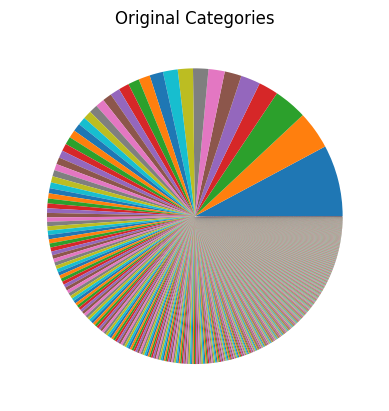

In [20]:
import matplotlib.pyplot as plt

plt.pie([category[1] for category in category_counts])
plt.title("Original Categories")
plt.show()


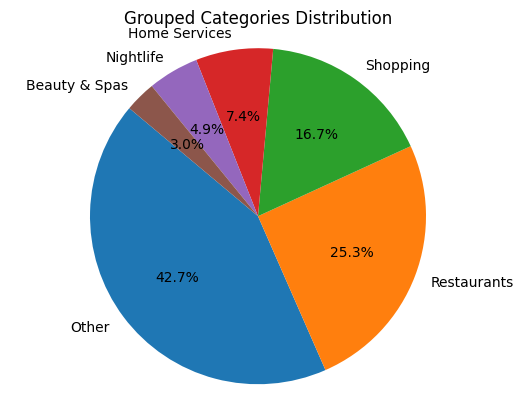

[('Other', 285423),
 ('Restaurants', 168929),
 ('Shopping', 111728),
 ('Home Services', 49733),
 ('Nightlife', 32750),
 ('Beauty & Spas', 20029)]

In [21]:
import matplotlib.pyplot as plt

# Define data for the pie chart
labels = top_grouped_categories
sizes = [count[1] for count in grouped_category_counts[:6]]

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.title('Grouped Categories Distribution')

# Show the pie chart
plt.show()

# print out the grouped categories and their counts 
grouped_category_counts



In [27]:
silent_remove(f"data/01_cleaned/{'sample/' if SAMPLE else ''}businesses.json")
with open(f"data/01_cleaned/{'sample' if SAMPLE else ''}/businesses.json", "a") as f:
    for business in businesses_dict.values():
        f.write(json.dumps(business) + "\n")

### Keyword Extraction

In [ ]:
stop_words = set(stopwords.words("english"))

# read business JSON file
with open(f"data/01_cleaned/{'sample/' if SAMPLE else ''}businesses.json") as f:
    businesses = [json.loads(line) for line in f]

# Extract keywords from each business entry for category and name attributes using dictionary
business_keywords = {}
for business in businesses:
    business_keywords[business["business_id"]] = {}
    business_keywords[business["business_id"]]["category"] = []
    business_keywords[business["business_id"]]["name"] = []
    for word in word_tokenize(business["categories"]):
        if word not in stop_words and word != "," and word != "&" and word != "-" and word != "(" and word != ")" and word != "." and word != "'" and word != "!" and word != "?" and word != ":" and word != ";" and word != "[" and word != "]" and word != "/":
            business_keywords[business["business_id"]]["category"].append(word)
    for word in word_tokenize(business["name"]):
        if word not in stop_words and word != "," and word != "&" and word != "-" and word != "(" and word != ")" and word != "." and word != "'" and word != "!" and word != "?" and word != ":" and word != ";" and word != "[" and word != "]" and word != "/":
            business_keywords[business["business_id"]]["name"].append(word)

# read review JSON file
with open(f"data/02_postprocessing/{'sample/' if SAMPLE else ''}reviews.json") as f:
    reviews = [json.loads(line) for line in f]

# Extract keywords from each review entry for text attribute using dictionary
review_keywords = {}
for review in reviews:
    review_keywords[review["review_id"]] = []
    for word in word_tokenize(review["text"]):
        if word not in stop_words and word != "," and word != "&" and word != "-" and word != "(" and word != ")" and word != "." and word != "'" and word != "!" and word != "?" and word != ":" and word != ";" and word != "[" and word != "]" and word != "/":
            review_keywords[review["review_id"]].append(word)

# Create a dictionary of business_id to a list of review_ids
business_review_dict = {}
for review in reviews:
    if review["business_id"] not in business_review_dict.keys():
        business_review_dict[review["business_id"]] = [review["review_id"]]
    else:
        business_review_dict[review["business_id"]].append(review["review_id"])

# combine keywords from all reviews, category, and name for each business
# some businesses do not have any reviews, so we only combine category and name keywords for those businesses using dictionary
business_keywords_combined = {}
for business in businesses:
    business_keywords_combined[business["business_id"]] = []
    if business["business_id"] in business_review_dict.keys():
        for review_id in business_review_dict[business["business_id"]]:
            business_keywords_combined[business["business_id"]] += review_keywords[review_id]
    business_keywords_combined[business["business_id"]] += business_keywords[business["business_id"]]["category"]
    business_keywords_combined[business["business_id"]] += business_keywords[business["business_id"]]["name"]



# print the keywords for each business with their name
for business in businesses:
    print(business["name"] + ": ")
    print(business_keywords_combined[business["business_id"]])
    print("\n")


